## fit the discharging shape of HV current when beam is off
the data was got from CSS data browser export function. 

In [1]:
# load data

import numpy as np
import pandas as pd

dhe = '1012'; module = 'W43_IB'

filename = 'hv_%s_beam.csv'%dhe

time = '# Time' 
curr = 'PXD:P%s:hv:CURR:cur Value'%dhe
volt = 'PXD:P%s:hv-load:VOLT:cur Value'%dhe
her = 'SKB2:BMHDCCT:CURRENT Value'
ler = 'SKB2:BMLDCCT:CURRENT Value'

data_orig = pd.read_csv(filename,delimiter='\t',thousands=',', decimal='.',skiprows=range(44))
print(data_orig.keys())
# print(data0.head())

## drop the duplicated records 
data = data_orig.drop_duplicates(subset='# Time')
## drop the rows containing Nan 
data.dropna(subset = [curr,volt,ler,her], inplace=True)

data[time] = pd.to_datetime(data[time], format='%Y-%m-%d %H:%M:%S.%f')

print(len(data.index))

Index(['# Time', 'PXD:P1012:hv:CURR:cur Value', 'SKB2:BMLDCCT:CURRENT Value',
       'SKB2:BMHDCCT:CURRENT Value', 'PXD:P1012:hv-load:VOLT:cur Value'],
      dtype='object')
18723


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:
## plotting functions

from matplotlib import pyplot as plt
import matplotlib.dates as mdate
from datetime import datetime


def plot_hv(sample,data = None):
    c=['tab:blue', 'tab:red','tab:green']

    fig0, ax0 = plt.subplots(figsize=(15,6))
    fig0.suptitle('%s - %s'%(dhe,module))
    
    zorder = 0

    if data is not None:
        ax1 = ax0.twinx()
        ax1.set_zorder(zorder); zorder += 1

        #data_timex = [mdate.date2num(datetime.strptime(t[:19], "%Y-%m-%d %H:%M:%S")) for t in data[time]]
        data_timex = [mdate.date2num(t) for t in data[time]]
        ax1.plot_date(data_timex, data[her],c=c[1],ls='',marker='.', label='HER')
        ax1.plot_date(data_timex, data[ler],c=c[2],ls='',marker='.', label='LER')
        ax1.set_ylabel('beam current')
#         ax1.set_ylim(top = 3000)
        ax1.legend(loc=2)
    
        ax0.set_zorder(zorder); zorder += 1
        ax0.set_facecolor("none")

    sample_timex =[mdate.date2num(t) for t in sample[time]]
    ax0.plot_date(sample_timex, sample[curr],c=c[0],ls='',marker='.', label=curr)
    ax0.set_ylabel(curr)
#     ax0.set_ylim(bottom = -1700)
    ax0.legend(loc=1)
    ax0.grid()

    return fig0

# fig0.autofmt_xdate()


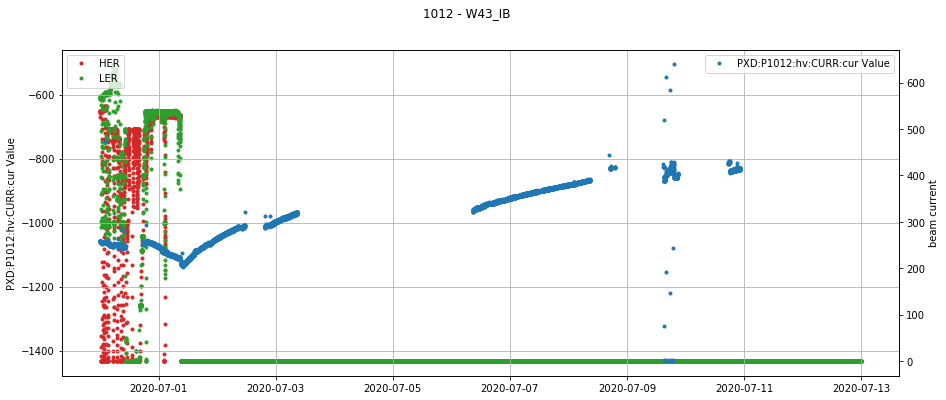

In [3]:
## plot HV current and beam currents

sample = data.loc[(data[volt]<-50000)]

fig = plot_hv(sample, data)

fig

['2020-07-01 10:00:00', '2020-07-02 09:00:00']


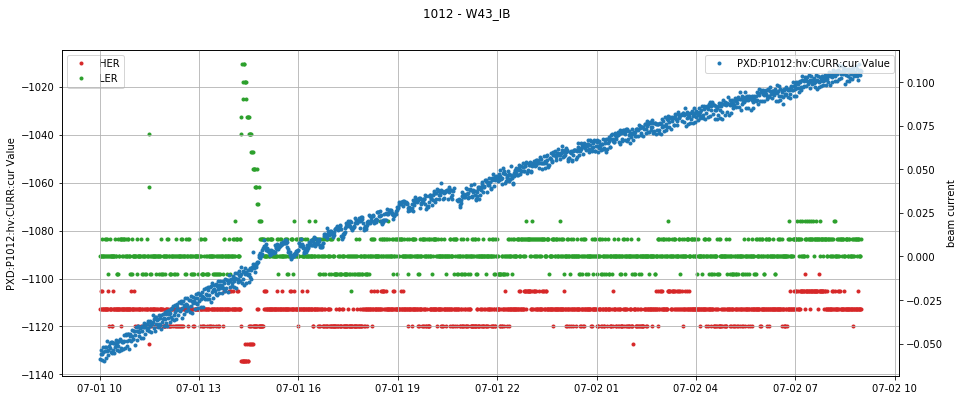

In [4]:
# 1012 
#discharge

period0 = ['2020-07-01 10:00:00', '2020-07-02 09:00:00']; curr_low = -1400; curr_high = -200
# period0 = ['2020-07-06 10:00:00', '2020-07-08 09:00:00']; curr_low = -1400; curr_high = -200

title='%s - %s'%(period0[0],period0[1])
print(period0)
period0 = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S") for t in period0]

data0 = data.loc[(data[time]>period0[0]) & (data[time]<period0[1])]
# sample0 = data0.loc[(data[volt]<-50000)] 
sample0 = data0.loc[(data[curr]<curr_high) & (data[curr]>curr_low) & (data[volt]<-50000)] 

fig0 = plot_hv(sample0,data0)

fig0


['2020-07-01 10:00:00', '2020-07-02 09:00:00']


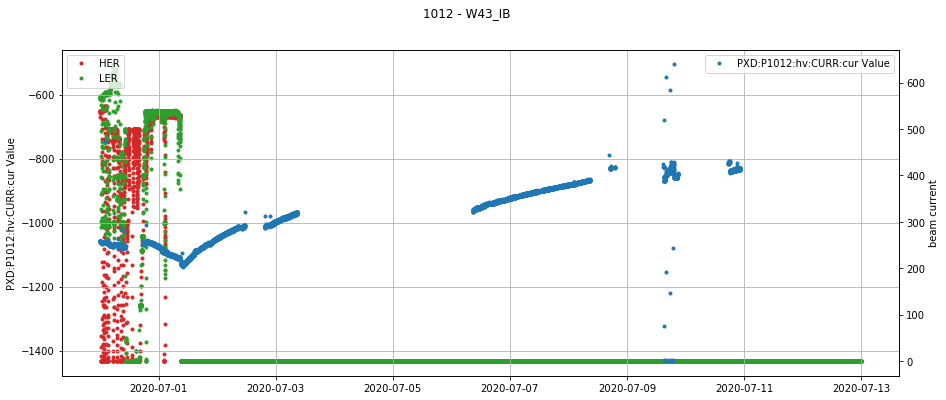

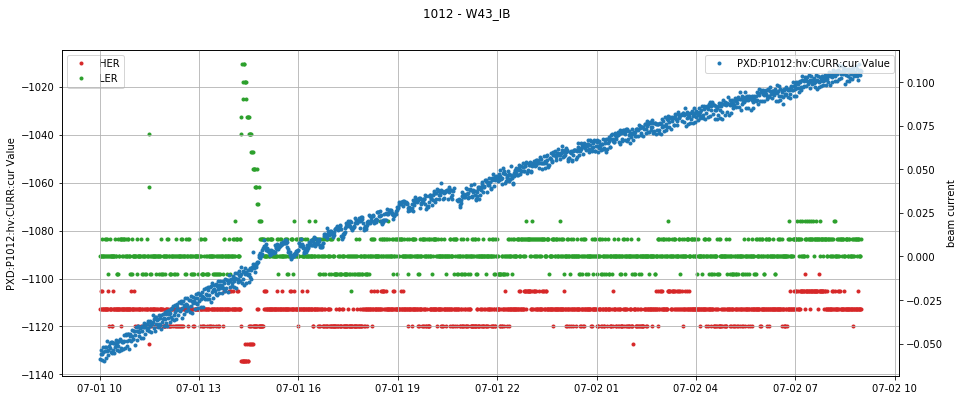

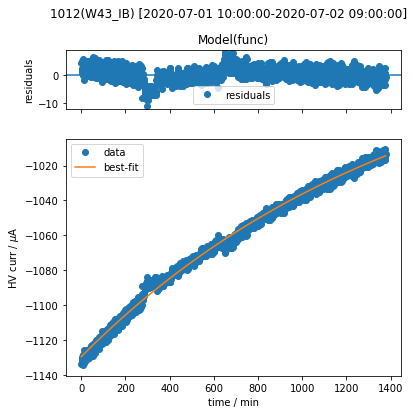

{'vs': -191.96845266092203, 'rc': 1503.250607776095, 'v0': -937.6185228585732}
best-fit Parameters
Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
rc      1503      100    1e+05    26.89     True     None     None
v0    -937.6    -1500      500    2.234     True     None     None
vs      -192    -1000      500    2.089     True     None     None
fit report
[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1373
    # variables        = 3
    chi-square         = 8862.13503
    reduced chi-square = 6.46871170
    Akaike info crit   = 2566.35610
    Bayesian info crit = 2582.03036
[[Variables]]
    vs: -191.968453 +/- 2.08870579 (1.09%) (init = -500)
    rc:  1503.25061 +/- 26.8928435 (1.79%) (init = 2000)
    v0: -937.618523 +/- 2.23355368 (0.24%) (init = -500)
[[Correlations]] (unreported correlations are < 0.100)
    C(vs, v0) = -0.997
    C(rc, v0) =  0.993
    C(vs, rc) = -0.982


In [5]:
#1012 lmfit 

from lmfit import Model, Parameter, report_fit
import numpy as np

def func(x, vs, rc, v0):
    return vs*np.exp(-x/rc)+v0


# discharge
period0 = ['2020-07-01 10:00:00', '2020-07-02 09:00:00']; curr_low = -1400; curr_high = -200
# period0 = ['2020-07-06 10:00:00', '2020-07-08 09:00:00']; curr_low = -1400; curr_high = -200


title='%s - %s'%(period0[0],period0[1])
print(period0)
period0 = [datetime.strptime(t, "%Y-%m-%d %H:%M:%S") for t in period0]

data0 = data.loc[(data[time]>period0[0]) & (data[time]<period0[1])]
# sample0 = data0.loc[(data[volt]<-50000)] 
sample0 = data0.loc[(data[curr]<curr_high) & (data[curr]>curr_low) & (data[volt]<-50000)] 

label = curr

epoch = sample0[time].iloc[0]

xdata = [ (t - epoch).total_seconds()/60.0 for t in sample0[time]]
ydata = sample0[curr].values

model = Model(func, independent_vars=['x'])

params = model.make_params()

params_ini = {'vs':[-500, -1000,500], 
          'rc':[2e3, 1e2,1e5],
          'v0':[-500, -1500,500]}

for key in params_ini:
    params[key].value = params_ini[key][0]
    params[key].min = params_ini[key][1]
    params[key].max = params_ini[key][2]
    

result = model.fit(ydata, params=params, x=xdata)

result.plot(xlabel='time / min', ylabel=r'HV curr / $\mu$A')
# result.plot_fit(xlabel='time / min', ylabel=r'HV curr / $\mu$A')
# result.plot_residuals()
plt.suptitle('%s(%s) [%s-%s]'%(dhe,module,period0[0],period0[1]))
plt.show()

print(result.values)

print('best-fit Parameters')
result.params.pretty_print()

print('fit report')
print(result.fit_report())

